In [144]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import ahkab
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from sympy.abc import f
from sympy import I
from scipy.constants import k
import scipy, scipy.interpolate
print("We're using ahkab %s" % ahkab.__version__)

We're using ahkab 0.18


In [166]:
# Build circuit.
# When components change, must rerun this cell for AC analysis to have new transfer function.

# Nonidealities
Av = 100 #voltage gain
ro = 200 #output resistance
Cload = 40e-15 #load

lpf = ahkab.Circuit('2nd Order Sallen-Key LPF')
# https://en.wikipedia.org/wiki/Sallen–Key_topology
lpf.add_capacitor('CL', 'out', lpf.gnd, Cload) #load

Rbase = 900
m = 1.5
Cbase = 9e-12
n = 1.5
R1val = Rbase*m
R2val = Rbase/m
C1val = Cbase*n
C2val = Cbase/n

lpf.add_resistor('R1', 'in', 'n1', R1val)
lpf.add_isource('Inr1', 'in', 'n1', dc_value=0, ac_value=0) #R1 noise current
lpf.add_resistor('R2', 'n1', 'n2', R2val)
lpf.add_isource('Inr2', 'n1', 'n2', dc_value=0, ac_value=0) #R2 noise current
lpf.add_capacitor('C1', 'n1', 'out', C1val)
lpf.add_capacitor('C2', 'n2', lpf.gnd, C2val)
lpf.add_vcvs('E1', 'out', lpf.gnd, 'n2', 'out', Av)
#lpf.add_resistor('RO', 'out', 'ne', ro) #DANGER: this blows up the solution
lpf.add_isource('Ine1', 'out', lpf.gnd, dc_value=0, ac_value=0) #op-amp total output noise current

# voltage sources for AC simulation
lpf.add_vsource('V1', 'in', lpf.gnd, dc_value=0, ac_value=1)
print(lpf)

* 2nd Order Sallen-Key LPF
CL out 0 4e-14
R1 in n1 1350
Inr1 in n1 type=idc value=0 
R2 n1 n2 600
Inr2 n1 n2 type=idc value=0 
C1 n1 out 1.35e-11
C2 n2 0 6e-12
E1 out 0 n2 out 100
Ine1 out 0 type=idc value=0 
V1 in 0 type=vdc value=0 vac=1 


In [151]:
# Vin to Vout analysis
opa = ahkab.new_op()
aca = ahkab.new_ac(start=1e3, stop=1e9, points=100)
syma = ahkab.new_symbolic(source='V1')
r = ahkab.run(lpf, [opa, aca])
rs, tfs = ahkab.run(lpf, syma)['symbolic']
r['op'].keys()
r['ac'].keys()

# Print symbolic transfer function for input to output
print(rs)
Hs = tfs['VOUT/V1']['gain']
print("Transfer function: %s\n" % Hs)
print("Poles: %s\n" % tfs['VOUT/V1']['poles'])
p0 = tfs['VOUT/V1']['poles'][0]
p1 = tfs['VOUT/V1']['poles'][1]

# Noise transfer functions for each source
rs_r1, tfs_r1 = ahkab.run(lpf, ahkab.new_symbolic(source='Inr1'))['symbolic']
rs_r2, tfs_r2 = ahkab.run(lpf, ahkab.new_symbolic(source='Inr2'))['symbolic']
rs_e1, tfs_e1 = ahkab.run(lpf, ahkab.new_symbolic(source='Ine1'))['symbolic']
Hs_r1 = tfs_r1['VOUT/INR1']['gain']
Hs_r2 = tfs_r2['VOUT/INR2']['gain']
Hs_e1 = tfs_e1['VOUT/INE1']['gain']
print("R1 noise current TF: %s\n" % Hs_r1)
print("R2 noise current TF: %s\n" % Hs_r2)
print("Opamp noise current TF: %s\n" % Hs_e1)

['VOUT', 'VIN', 'VN1', 'VN2', 'I(E1)', 'I(V1)']

['f', 'Vout', 'Vin', 'Vn1', 'Vn2', 'I(E1)', 'I(V1)']

Symbolic simulation results for '2nd Order Sallen-Key LPF' (netlist None).
Run on 2019-03-14 07:02:12.
I[E1]	 = (-INE1*(C1*R1*R2*s + R1 - (C2*R2*s + 1.0)*(C1*R1*R2*s + R1 + R2)) - INR2*R2*s*(C1**2*R1*R2*s + C1*R1 - (C1 + CL)*(C1*R1*R2*s + R1 + R2)) + R1*R2*s*(INR1 - INR2)*(-C1*(C2*R2*s + 1.0) + C1 + CL) + R2*V1*s*(-C1*(C2*R2*s + 1.0) + C1 + CL))/(C1*R1*R2*s + R1 - (C2*R2*s + 1.0)*(C1*R1*R2*s + R1 + R2))
I[V1]	 = -s*(C1*C2*INR1*R1*R2*s + C1*C2*R2*V1*s - C1*INR2*R2 + C2*INR1*R1 + C2*INR2*R2 + C2*V1)/(C1*C2*R1*R2*s**2 + C2*R1*s + C2*R2*s + 1.0)
VIN	 = V1
VN1	 = -R2*(INR2*R1*(C1*R2*s + 1.0) + R1*(INR1 - INR2)*(C2*R2*s + 1.0) + V1*(C2*R2*s + 1.0))/(C1*R1*R2*s + R1 - (C2*R2*s + 1.0)*(C1*R1*R2*s + R1 + R2))
VN2	 = (C1*INR2*R1*R2*s + INR1*R1 + INR2*R2 + V1)/(C1*C2*R1*R2*s**2 + C2*R1*s + C2*R2*s + 1.0)
VOUT	 = (C1*INR2*R1*R2*s + INR1*R1 + INR2*R2 + V1)/(C1*C2*R1*R2*s**2 + C2*R1*s + C2*R2*s + 1.0)

Transfer function: 1/(C1*C2*R1*R2*s**2 + C2*R1*s + C2*R2*s + 1.0)

Poles: [0.5*(-sqrt(C2)*(R1 + R2

In [ ]:
# Input a ZPK object

# Solve for R's & C's given poles

In [147]:
# Evaluate w/ chosen R & C values.

s, R1, R2, C1, C2 = rs.as_symbols('s R1 R2 C1 C2')
#s, R1, R2, C1, C2, E1, RO, CL = rs.as_symbols('s R1 R2 C1 C2 E1 RO CL') # w/ non-zero ro

# Passband/stopband
HS = sp.lambdify(f, Hs.subs({s:I*f*2*np.pi, R1:R1val, R2:R2val, C1:C1val, C2:C2val})) #, E1:Av, RO:ro, CL:Cload}))
print("DC gain from symbolic analysis: %g dB\n" % (20*np.log10(np.abs(HS(0)))))
att = -20*np.log10(np.abs(HS(20e6)))
print("Maximum attenuation in the passband < %g Hz (%g dB) meets spec?\n=> %r\n" % (20e6, att, att < 3))
att = -20*np.log10(np.abs(HS(200e6)))
print("Minimum attenuation in the stopband > %g Hz (%g dB) meets spec?\n=> %r\n" % (200e6, att, att > 55))

# Group Delay
grp_del = (-np.diff(np.unwrap(np.angle(HS(r['ac'].get_x())))) / np.diff(r['ac']['f'])) * 1e9
grp_del_ripple = grp_del.max() - grp_del[0]

print("Group delay (%g ns) meets spec?\n=> %r\n" % (grp_del_ripple, grp_del_ripple < 3))

# Poles
p0s = p0.subs({R1:R1val, R2:R2val, C1:C1val, C2:C2val})/2/np.pi
p1s = p1.subs({R1:R1val, R2:R2val, C1:C1val, C2:C2val})/2/np.pi
print("First pole: %g + %gj Hz (%g)" % (sp.re(p0s), sp.im(p0s), sp.Abs(p0s)))
print("Second pole: %g + %gj Hz (%g)\n" % (sp.re(p1s), sp.im(p1s), sp.Abs(p1s)))

# Find how much input referred integrated noise there is
# Then check if DR is achievable based on supply & V*
print("Simulation temp: %g K\n" % ahkab.constants.Tref)
kT4 = 4*k*ahkab.constants.Tref
# Assume all opamp noise is from a single transistor w/ some effective gm
gamma = 2/3
gm = 0.005
in2_r1 = kT4/R1val
in2_r2 = kT4/R2val
in2_e1 = kT4*gamma*gm
vi2_r1 = sp.integrate(sp.Abs(((Hs_r1/Hs).subs({s:I*f*2*np.pi, R1:R1val, R2:R2val, C1:C1val, C2:C2val}))**2) * in2_r1, (f, 0, 20e6))
print("Input referred noise power from R1: %g V^2" % vi2_r1)
vi2_r2 = sp.integrate(sp.Abs(((Hs_r2/Hs).subs({s:I*f*2*np.pi, R1:R1val, R2:R2val, C1:C1val, C2:C2val}))**2) * in2_r2, (f, 0, 20e6))
print("Input referred noise power from R2: %g V^2" % vi2_r2)
vi2_e1 = sp.integrate(sp.Abs(((Hs_e1/Hs).subs({s:I*f*2*np.pi, R1:R1val, R2:R2val, C1:C1val, C2:C2val}))**2) * in2_e1, (f, 0, 20e6))
print("Input referred noise power from opamp: %g V^2" % vi2_e1)
vi2_tot = (vi2_r1 + vi2_r2 + vi2_e1).evalf()
print("Total input referred noise power: %g V^2" % vi2_tot)
SNR = 10**(50/10)
vi_min = sp.sqrt(vi2_tot*SNR*2)
Vstar = 0.1 #assumption is that we can swing up to supply-V*
print("Min. req'd voltage swing (zero-pk) (%g V) attainable?\n=> %r" % (vi_min, vi_min < 0.6-Vstar))

DC gain from symbolic analysis: 0 dB

Maximum attenuation in the passband < 2e+07 Hz (3.35053 dB) meets spec?
=> False

Minimum attenuation in the stopband > 2e+08 Hz (40.3118 dB) meets spec?
=> False

Group delay (12.5784 ns) meets spec?
=> False

First pole: -1.41908e+07 + 1.35903e+07j Hz (1.96488e+07)
Second pole: -1.41908e+07 + -1.35903e+07j Hz (1.96488e+07)

Simulation temp: 300 K

Input referred noise power from R1: 4.4733e-10 V^2
Input referred noise power from R2: 5.46413e-10 V^2
Input referred noise power from opamp: 0 V^2
Total input referred noise power: 9.93743e-10 V^2
Min. req'd voltage swing (zero-pk) (0.0140978 V) attainable?
=> True


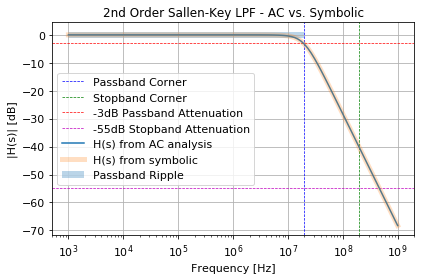

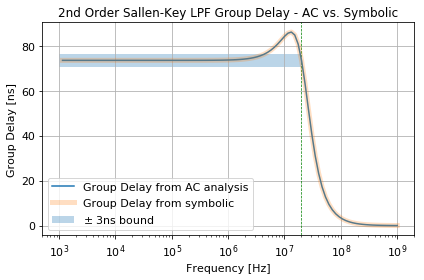

In [165]:
# Plot resulting gain, phase, group delay
fig, ax = plt.subplots()
plt.axvline(x=20e6, linestyle = '--', linewidth=0.7, color='b', label='Passband Corner')
plt.axvline(x=200e6, linestyle = '--', linewidth=0.7, color='g', label='Stopband Corner')
plt.axhline(y=-3, linestyle = '--', linewidth=0.7, color='r', label='-3dB Passband Attenuation')
plt.axhline(y=-55, linestyle = '--', linewidth=0.7, color='m', label='-55dB Stopband Attenuation')
ax.fill([r['ac']['f'][0], 20e6, 20e6, r['ac']['f'][0]], [1, 1, -1, -1], alpha=0.3, label='Passband Ripple')
plt.semilogx(r['ac']['f'], 20*np.log10(np.abs(r['ac']['Vout'])), '-', label='H(s) from AC analysis')
plt.semilogx(r['ac']['f'], 20*np.log10(np.abs(HS(r['ac'].get_x()))), '-', lw=5, alpha=.25, label='H(s) from symbolic')
#plt.semilogx(r['ac']['f'], 20*np.log10(np.abs(HS_r1(r['ac'].get_x()))), '-', label='H(s) from resistor to output')
plt.xlabel('Frequency [Hz]')
plt.ylabel('|H(s)| [dB]')
plt.title(lpf.title + " - AC vs. Symbolic")
plt.legend(); plt.grid(True); plt.tight_layout();

#plt.figure()
#plt.semilogx(r['ac']['f'], 180/np.pi*np.angle(r['ac']['Vout']), '-', label='Phase from AC analysis')
#plt.semilogx(r['ac']['f'], 180/np.pi*(np.angle(HS(r['ac'].get_x()))), '-', lw=5, alpha=.25, label='Phase from symbolic')
#plt.xlabel('Frequency [Hz]')
#plt.ylabel('Phase [deg]')
#plt.legend(); plt.grid(True);

fig, ax = plt.subplots()
plt.axvline(x=20e6, linestyle = '--', linewidth=0.7, color='g')
group_delay = (-np.diff(np.unwrap(np.angle(r['ac']['Vout']))) / np.diff(r['ac']['f'])) * 1e9
ax.fill([r['ac']['f'][0], 20e6, 20e6, r['ac']['f'][0]], [group_delay[0] + 3, group_delay[0] + 3, group_delay[0] - 3, group_delay[0] - 3], alpha=0.3, label='$\pm$ 3ns bound')
plt.semilogx(r['ac']['f'][1:], (-np.diff(np.unwrap(np.angle(r['ac']['Vout']))) / np.diff(r['ac']['f'])) * 1e9, '-', label='Group Delay from AC analysis')
plt.semilogx(r['ac']['f'][1:], (-np.diff(np.unwrap(np.angle(HS(r['ac'].get_x())))) / np.diff(r['ac']['f'])) * 1e9, '-', lw=5, alpha=.25, label='Group Delay from symbolic')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Group Delay [ns]')
plt.title(lpf.title + " Group Delay - AC vs. Symbolic")
plt.legend(); plt.grid(True); plt.tight_layout();

plt.show();

In [149]:
# Check against AC simulation
# DC gain
dc_gain = 20*np.log10(np.abs(r['ac']['Vout'][0]))
print("DC gain from AC analysis: %g dB" % (dc_gain))

# Normalize the output to the low frequency value and convert to array
norm_out = np.abs(r['ac']['Vout'])/np.abs(r['ac']['Vout']).max()
# Convert to dB
norm_out_db = 20*np.log10(norm_out)
# Get frequencies
frequencies = r['ac']['f']
# call scipy to interpolate
norm_out_db_interpolated = scipy.interpolate.interp1d(frequencies, norm_out_db)

print("Maximum attenuation in the passband < %g Hz is %g dB" % (20e6, -1.0*norm_out_db_interpolated(20e6)))
print("Minimum attenuation in the stopband > %g Hz is %g dB" % (200e6, -1.0*norm_out_db_interpolated(200e6)))

DC gain from AC analysis: -2.96356e-08 dB
Maximum attenuation in the passband < 2e+07 Hz is 3.35316 dB
Minimum attenuation in the stopband > 2e+08 Hz is 40.2699 dB
